# Quantum Eigenvalue Transformation

In [2]:
import numpy as np
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

In [3]:
X_gate = np.array([[0, 1], [1, 0]], dtype = 'complex_')
Y_gate = np.array([[0, -1j], [1j, 0]], dtype = 'complex_')
Z_gate = np.array([[1, 0], [0, -1]], dtype = 'complex_')

H_gate = np.array([[1, 1], [1, -1]], dtype = 'complex_') / np.sqrt(2)

def R_x(theta):
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]], dtype = 'complex_')

def R_y(theta):
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]], dtype = 'complex_')

def R_z(theta):
    return np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]], dtype = 'complex_')

## Hamiltonian

In [4]:
H = X_gate @ X_gate @ Y_gate @ Z_gate + X_gate @ Y_gate @ Z_gate + Y_gate @ Z_gate + Z_gate @ X_gate
print(H)

[[ 0.+1.j  1.+2.j]
 [-1.+2.j  0.+1.j]]


## Block encoding

$$
U =
\begin{bmatrix}
\mathcal{H} & \cdot \\
\cdot & \cdot
\end{bmatrix}
=
\begin{bmatrix}
\mathcal{H} & \sqrt{I - \mathcal{H}^2} \\
\sqrt{I - \mathcal{H}^2} & -\mathcal{H}
\end{bmatrix}
=
Z \otimes \mathcal{H} + \mathcal{H} \otimes \sqrt{\mathcal{I} - \mathcal{H}^2}
$$

In [5]:
def U(H):
    '''
    Returns a block encoding of a Hamiltonian matrix
    '''
    return np.kron(Z_gate, H) + np.kron(X_gate, np.sqrt(np.eye(2) - sqrtm(H)))

In [6]:
print(U(H))

[[ 0.        +1.j          1.        +2.j          0.32831659-0.36996932j
   0.4358115 -0.93136437j]
 [-1.        +2.j          0.        +1.j          0.80632047-0.63813679j
   0.32831659-0.36996932j]
 [ 0.32831659-0.36996932j  0.4358115 -0.93136437j  0.        -1.j
  -1.        -2.j        ]
 [ 0.80632047-0.63813679j  0.32831659-0.36996932j  1.        -2.j
   0.        -1.j        ]]


## Projector

For $\mathcal{H} \in \mathbb{C}^{2 \times 2}$ the projector must be $\Pi =
\begin{bmatrix}
\mathit{I}_2 & \cdot \\
\cdot & \cdot
\end{bmatrix}$

In [7]:
projector = np.block([[np.eye(2), np.zeros((2,2))], [np.zeros((2,2)), np.zeros((2,2))]])

The projector-controlled phase-shift operation is defines as $\Pi_{\phi} = e^{i\phi (2\Pi-I)}$

In [8]:
def phase_shift(phi):
    '''
    performs the projector-controlled phase shift operation for a given phase phi and a globaly defined projector Pi
    '''
    return expm(1j*phi*(2*projector - np.eye(projector.shape[0])))

A controlled version of the projector-controlled phase-shift operation is defined as $C(\Pi_{\phi})$

In [9]:
def c_phase_shift(phi):
    Pi_phi = phase_shift(phi)
    zero_projector = np.outer([1, 0], [1, 0])
    one_projector = np.outer([0, 1], [0, 1])
    c_phase_shift = np.kron(zero_projector, np.eye(4)) + np.kron(one_projector, Pi_phi)
    return c_phase_shift

## Eigenvalue Transformation

$$
U_{\vec{\phi}} = \prod_{k=1}^{d/2} \Pi_{\phi_{2k-1}} U^{\dagger} \Pi_{\phi_{2k}} U
$$

In [10]:
def eigenval_transform(phi_vec, U):
    '''
    Performs the eigenvalue transformation
    '''
    d = len(phi_vec) - 1
    U_dagger = np.conj(U).T
    if (d % 2 == 0):
        result = 1
        for k in range(1, d//2):
            result = result @ phase_shift(phi_vec[2*k-1]) @ U_dagger @ phase_shift(phi_vec[2*k]) @ U
        return result
    else:
        result = phase_shift(phi_vec[1]) @ U
        for k in range (1, (d-1)//2):
            result = result @ phase_shift(phi_vec[2*k]) @ U_dagger @ phase_shift(phi_vec[2*k+1]) @ U
        return result

## Trivial Example

In [11]:
# apply eigenvalue transformation
phi_vec_triv = [0, 0]
transformed = eigenval_transform(phi_vec_triv, U(H))

# print original Hamiltonian
print("original Hamiltonian")
print(H)
print("\n")
# print transformed output
print("transformed")
print(projector @ transformed @ projector)
print("\n")

# calculate the expected result
print("expected eigenvalues")
w, v = np.linalg.eig(H)
poly_H = w[0] * v[0].reshape(2, 1) @ v[0].reshape(1, 2).conjugate() + w[1] * v[1].reshape(2, 1) @ v[1].reshape(1, 2).conjugate()
print(poly_H)

original Hamiltonian
[[ 0.+1.j  1.+2.j]
 [-1.+2.j  0.+1.j]]


transformed
[[ 0.+1.j  1.+2.j  0.+0.j  0.+0.j]
 [-1.+2.j  0.+1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]


expected eigenvalues
[[ 1.66533454e-16+1.j  1.00000000e+00+2.j]
 [-1.00000000e+00+2.j  2.77555756e-17+1.j]]


## Controlled QSVT

$$
C(U_{\vec{\phi}}) = \prod_{k=1}^{d/2} C(\Pi_{\phi_{2k-1}}) U^{\dagger} C(\Pi_{\phi_{2k}}) U
$$

In [12]:
def C_QSVT(phi_vec, U):
    '''
    Performs the controlled quantum singular value transformation
    '''
    # extend U
    zero_projector = np.outer([1, 0], [1, 0])
    one_projector = np.outer([0, 1], [0, 1])
    U = np.kron(zero_projector, np.eye(4)) + np.kron(one_projector, U)

    d = len(phi_vec) - 1
    U_dagger = np.conj(U).T
    if (d % 2 == 0):
        result = np.eye(8)
        for k in range(1, d//2):
            result = result @ c_phase_shift(phi_vec[2*k-1]) @ U_dagger @ c_phase_shift(phi_vec[2*k]) @ U
        return result
    else:
        result = c_phase_shift(phi_vec[1]) @ U
        for k in range (1, (d-1)//2):
            result = result @ c_phase_shift(phi_vec[2*k]) @ U_dagger @ c_phase_shift(phi_vec[2*k+1]) @ U
        return result

## The Eigenvalue Threshold Problem

#### Calculate the phase angles

[pyqsp.poly.PolyEfilter] degree=30, delta=0.3
[PolyTaylorSeries] max [0.94955034] is at [2.19000128e-08]: normalizing
[PolyTaylorSeries] average error = 0.009629178075583878 in the domain [-1, 1] using degree 30


c:\Python311\Lib\site-packages\scipy\interpolate\_polyint.py:502: UserWarning: 31 degrees provided, degrees higher than about thirty cause problems with numerical instability with 'KroghInterpolator'
  P = KroghInterpolator(xs, f(xs))


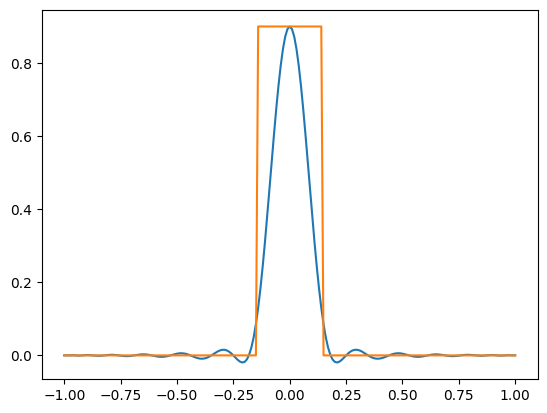

In [13]:
import pyqsp

pg = pyqsp.poly.PolyEigenstateFiltering()
pcoeffs, scale = pg.generate(30, 0.3, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")


def target_filt(x, delta, scale=1):
    """
    Target function for eigenvalue filtering.
    """
    return scale * (np.sign(x + 0.5*delta) - np.sign(x - 0.5*delta)) / 2

plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), label="target function")

### Actual result

In [14]:
#phi_vec_eig_val_thresh = [0.73930816, -0.69010006, -0.63972139, -0.47754554, 0.81797049, 0.09205065, -0.87660105, 0.13460844, 0.23892207, 1.32216648, -2.90267058, 0.13460844, 2.2649916, 0.09205065, -2.32362216, 2.66404712, -0.63972139, -0.69010006, 2.31010449]
phi_vec_eig_val_thresh = pcoeffs
H_I_I = np.kron(H_gate, np.kron(np.eye(2), np.eye(2)))
psi = np.array([[1],[0],[0],[0],[0],[0],[0],[0]])
eig_val_thresh_circuit = H_I_I @ C_QSVT(phi_vec_eig_val_thresh, U(H)) @ H_I_I
psi = eig_val_thresh_circuit @ psi

# M_000 = |000><000| + |001><001| + |010><010| + |011><011|
M_000 = np.outer([1,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0]) + np.outer([0,1,0,0,0,0,0,0], [0,1,0,0,0,0,0,0]) + np.outer([0,0,1,0,0,0,0,0], [0,0,1,0,0,0,0,0]) + np.outer([0,0,0,1,0,0,0,0], [0,0,0,1,0,0,0,0])
print("measurement result")
print(np.conj(psi).T @ np.conj(M_000).T @ M_000 @ psi)

measurement result
[[8.38426914e+28+0.j]]


$\epsilon = \frac14 \zeta$

### Expexted result

In [15]:
print("expected eigenvalues")
w, v = np.linalg.eig(H)
print(w)
l_th = 0.3 / 2
delta_l = 0.0

print("\n")
print("eigenvalues smaller that λ_lth - Δ_l?")
[l < (l_th - delta_l) for l in w]

expected eigenvalues
[0.00000000e+00+3.23606798j 1.11022302e-16-1.23606798j]


eigenvalues smaller that λ_lth - Δ_l?


[True, True]

## Hamiltonian Simulation

#### Sine

15.537708063830353
R=7
[PolySineTX] rescaling by 0.5.


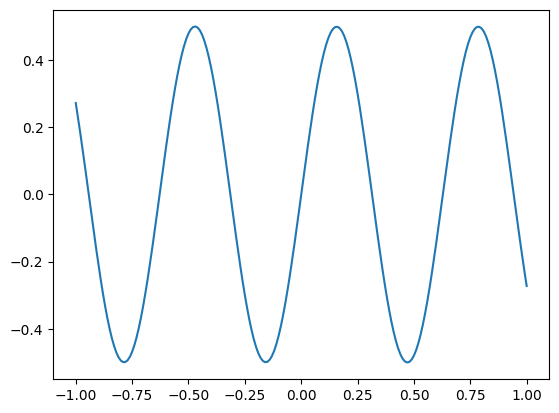

In [21]:
pg = pyqsp.poly.PolySineTX()
sin_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(sin_pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")

#### Cosine

15.537708063830353
R=7
[PolyCosineTX] rescaling by 0.5.


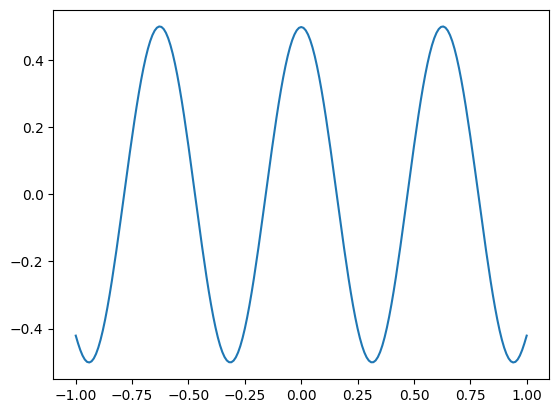

In [22]:
pg = pyqsp.poly.PolyCosineTX()
cos_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(cos_pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")

### Result

In [23]:
H_I_I = np.kron(H_gate, np.kron(np.eye(2), np.eye(2)))
psi = np.array([[1],[0],[0],[0],[0],[0],[0],[0]])
hsim_circuit = H_I_I @ C_QSVT(sin_pcoeffs, U(H)) @ C_QSVT(cos_pcoeffs, U(H)) @ H_I_I
psi = hsim_circuit @ psi

print(hsim_circuit)

[[-3.76368095e+13+2.06506429e+13j -2.03503201e+13+2.98806731e+13j
  -2.10129793e+13-9.07927278e+12j -2.13787603e+13+3.62372402e+12j
   3.76368095e+13-2.06506429e+13j  2.03503201e+13-2.98806731e+13j
   2.10129793e+13+9.07927278e+12j  2.13787603e+13-3.62372402e+12j]
 [-4.02175713e+13+2.95294173e+12j -2.90534868e+13+1.75903222e+13j
  -1.43666372e+13-1.59506827e+13j -1.96411086e+13-5.25800644e+12j
   4.02175713e+13-2.95294173e+12j  2.90534868e+13-1.75903222e+13j
   1.43666372e+13+1.59506827e+13j  1.96411086e+13+5.25800644e+12j]
 [-3.86345130e+13-1.81152512e+13j -3.58915752e+13+1.16082692e+12j
  -5.21292946e+12-2.23496107e+13j -1.56569148e+13-1.51008359e+13j
   3.86345130e+13+1.81152512e+13j  3.58915752e+13-1.16082692e+12j
   5.21292946e+12+2.23496107e+13j  1.56569148e+13+1.51008359e+13j]
 [-2.73692614e+13-2.97184302e+13j -3.18673997e+13-1.18400517e+13j
   3.43881211e+12-2.14991475e+13j -8.32852320e+12-1.88810608e+13j
   2.73692614e+13+2.97184302e+13j  3.18673997e+13+1.18400517e+13j
  -3.43

### Expected result

In [24]:
expm(-1j*H*10)

array([[5.66284483e+13+0.0000000e+00j, 5.06500239e+13-2.5325012e+13j],
       [5.06500239e+13+2.5325012e+13j, 5.66284483e+13+0.0000000e+00j]])